# NeRFの学習

## ロード/ディレクトリ設定

In [1]:
import os
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nerf_tutorial.colmap_utils import (
    extract_camera_info,
    extract_image_info,
    extract_points3D,
    undistort_image,
    calc_bds
)
from nerf_tutorial.intrinsics import Intrinsic
from nerf_tutorial.extrinsics import PoseExtrinsic, RVecExtrinsic
from nerf_tutorial.nerf import NeRFConfig, NeRF, NeRFLoss
from nerf_tutorial.visualization_utils import plot_cameras
from nerf_tutorial.datasets import ImgSampleDataset, collate_fn_sample

In [2]:
base_dir = os.path.dirname(os.getcwd())

data_dir = os.path.join(base_dir, "dataset", "laplace")#"colmap_project_dir")
image_dir = os.path.join(data_dir, "20210820_laplace")#"colmap_image_dir")
out_dir = os.path.join(base_dir, "results", "original_nerf")

if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

## COLMAP推定結果(txtファイル)の読み込み

In [3]:
camera_infos = \
    extract_camera_info(os.path.join(data_dir, "cameras.txt"))
camera_infos

[{'CAMERA_ID': '1',
  'MODEL': 'OPENCV',
  'WIDTH': 3000,
  'HEIGHT': 2000,
  'cmtx': array([[2.06903e+03, 0.00000e+00, 1.50000e+03],
         [0.00000e+00, 2.06827e+03, 1.00000e+03],
         [0.00000e+00, 0.00000e+00, 1.00000e+00]]),
  'dist': array([ 0.00222674, -0.00248576,  0.00103703,  0.00043848])}]

In [4]:
image_infos = \
    extract_image_info(os.path.join(data_dir, "images.txt"))
len(image_infos), image_infos[0]

(175,
 {'IMAGE_ID': '229',
  'CAMERA_ID': '1',
  'NAME': 'DSC03189.JPG',
  'pose': array([[-0.45080376, -0.36906727,  0.8127517 ,  1.63852   ],
         [ 0.49517999,  0.65417065,  0.57171456, -0.720368  ],
         [-0.74267944,  0.66018945, -0.11214786,  1.16716   ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]])})

In [5]:
xyzs, rgbs, vis = \
    extract_points3D(os.path.join(data_dir, "points3D.txt"), image_infos)
xyzs.shape, rgbs.shape, vis.shape

((23176, 3), (23176, 3), (23176, 175))

## データセット構築
- 画像のレンズ歪み補正
- ポーズ行列修正

In [6]:
images, poses, cmats = [], [], []
W, H = 1200, 800
size = (W, H)

for image_info in image_infos:

    # undistort image
    img, K = undistort_image(
        image_info, camera_infos, image_dir, size=size)
    rgb = (np.array(img).astype(np.float32) / 255.)[:, :, :3]
    rgb = rgb.reshape(-1, 3)
    images.append(rgb)
    poses.append(image_info["pose"])

    # assume only one camera was used.
    if len(cmats) == 0:
        cmats.append(K)
    if (cmats[0] - K).sum() != 0:
        raise ValueError("multiple intrinsic detected.")

images = np.stack(images)

# pose matrix in colmap output is world_coordinate -> camera_coordinate.
# NeRF use inverse transformation.
poses = np.linalg.inv(np.stack(poses))

print(images.shape, poses.shape, len(cmats))

(175, 960000, 3) (175, 4, 4) 1


In [7]:
cmat = cmats[0]
fx = cmat[0, 0]
fy = cmat[1, 1]
cx = cmat[0, 2]
cy = cmat[1, 2]
fx, fy, cx, cy

(828.646722424688, 828.4677311946216, 601.8641926221954, 401.77469006879346)

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


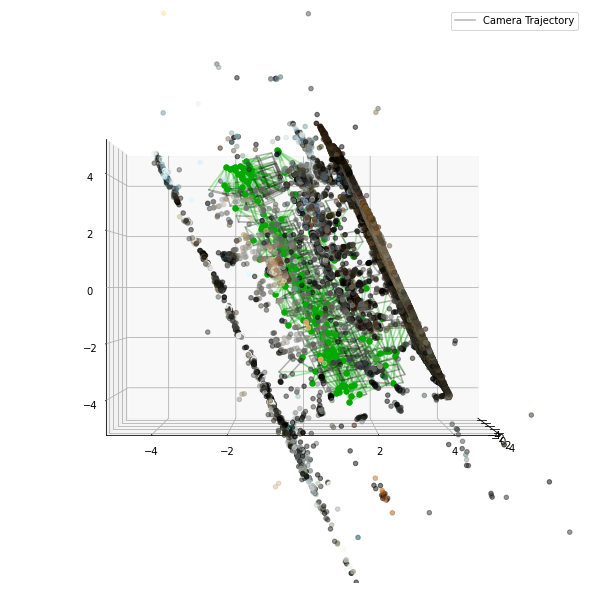

In [8]:
# check plot area by comparing with colmap's pointcloud.
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)

plot_cameras(ax, poses.astype(np.float32), 
             [fx, fy], [cx, cy], [W, H], "Camera Trajectory")
ax.scatter(xyzs[:, 0], xyzs[:, 1], xyzs[:, 2],
           c=rgbs/255., alpha=0.5)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
ax.view_init(elev=0, azim=0)
plt.legend()
plt.show()

In [9]:
bsz = 4
train_dataset = ImgSampleDataset(images)
loader = torch.utils.data.DataLoader(
    train_dataset, bsz, shuffle=True, collate_fn=collate_fn_sample)
print(len(train_dataset), len(loader))

175 44


## 座標の正規化

In [10]:
bds_min, bds_max = calc_bds(xyzs, poses, vis)
poses[:, :3, 3] /= bds_max
bds_min, bds_max

(1.3400427278466318, 15.082476742690913)

## NeRFの呼び出し

In [11]:
device = torch.device("cuda:4")

# NeRF
config = NeRFConfig()
nerf = NeRF(**config.nerf_kwargs())

# camera parameters
intrinsic = Intrinsic(
    [W, H], focals=[fx, fy], cxcy=[cx, cy],
    **config.intrinsic_kwargs())

if config.nerfmm:
    extrinsic = RVecExtrinsic(
        len(train_dataset), poses, **config.extrinsic_kwargs())
else:
    extrinsic = PoseExtrinsic(
        len(train_dataset), poses, **config.extrinsic_kwargs())

loss_func = NeRFLoss(nerf, intrinsic=intrinsic, extrinsic=extrinsic)
loss_func.to(device)

NeRFLoss(
  (nerf): NeRF(
    (rf_c): RadianceField(
      (layer0): Linear(in_features=60, out_features=256, bias=True)
      (layer1): Linear(in_features=256, out_features=256, bias=True)
      (layer2): Linear(in_features=256, out_features=256, bias=True)
      (layer3): Linear(in_features=256, out_features=256, bias=True)
      (layer4): Linear(in_features=256, out_features=256, bias=True)
      (layer5): Linear(in_features=316, out_features=256, bias=True)
      (layer6): Linear(in_features=256, out_features=256, bias=True)
      (layer7): Linear(in_features=256, out_features=256, bias=True)
      (sigma): Linear(in_features=256, out_features=1, bias=True)
      (layer8): Linear(in_features=256, out_features=256, bias=True)
      (layer9): Linear(in_features=280, out_features=128, bias=True)
      (layer10): Linear(in_features=128, out_features=128, bias=True)
      (layer11): Linear(in_features=128, out_features=128, bias=True)
      (layer12): Linear(in_features=128, out_feature

In [12]:
optimizer_nerf = torch.optim.Adam(
    loss_func.nerf.parameters(), lr=5e-4, betas=(0.9, 0.999))
scheduler_nerf = torch.optim.lr_scheduler.StepLR(
    optimizer_nerf, step_size=3000, gamma=0.1)

optimizer_camera = torch.optim.Adam([
        {'params': loss_func.intrinsic.parameters()},
        {'params': loss_func.extrinsic.parameters()}
    ], lr=1e-3, betas=(0.9, 0.999))
scheduler_camera = torch.optim.lr_scheduler.ExponentialLR(
    optimizer_camera, gamma=0.9977)

optimizers = [optimizer_nerf, optimizer_camera]
scheduler2step = {
    scheduler_nerf: 1,
    scheduler_camera: 1,
}

## NeRFの学習

In [ ]:
results = {
    "loss": [],
    "lr": [],
}

num_epoch = 2000
log_step = 10
save_step = 100

iter_passed = 0
diff_c2f_by_epoch = 1. / (config.barf_start_epoch-config.barf_end_epoch)
diff_c2f_by_epoch = torch.tensor(diff_c2f_by_epoch, dtype=torch.float32)
barf_alpha = torch.tensor(0., dtype=torch.float32)

for epoch in range(num_epoch):
    sum_loss = 0.
    
    if hasattr(loss_func.nerf, "alpha"):
        if epoch >= config.barf_start_epoch and epoch < config.barf_end_epoch:
            barf_alpha += diff_c2f_by_epoch
            loss_func.nerf.alpha.data.copy_(barf_alpha)
        elif epoch == config.barf_end_epoch:
            loss_func.nerf.alpha.data.copy_(
                torch.tensor(1., dtype=torch.float32))
    
    # training for one epoch
    loss_func.train()
    for iter_, batch in enumerate(loader):
        loss_func.zero_grad()
        
        loss = loss_func(batch)
        _loss = loss.item()
        sum_loss += _loss
        iter_passed += 1
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
    
    # logging
    now_lr = [
        optimizer.param_groups[0]["lr"]
        for optimizer in optimizers
    ]
    sum_loss = sum_loss / len(loader)
    
    if epoch % log_step == 0:
        if hasattr(loss_func.nerf, "alpha"):
            print("epoch: {}\titer: {}\tlr: {}\talpha: {:.7f}\tloss: {:.5f}".format(
                epoch, iter_passed, now_lr, loss_func.nerf.alpha.item(), sum_loss))
        else:
            print("epoch: {}\titer: {}\tlr: {}\tloss: {:.5f}".format(
                epoch, iter_passed, now_lr, sum_loss))
    
    results["loss"].append(sum_loss)
    results["lr"].append(now_lr)
    
    # sdcheduling
    if scheduler2step is not None:
        for scheduler, schedule_step in scheduler2step.items():
            if epoch % schedule_step == 0:
                scheduler.step()
    
    with open(os.path.join(out_dir, "log.json"), "w") as fw:
        json.dump(results, fw, indent=4)
    
    # model saving
    if epoch % save_step == 0:
        torch.save({
            "epoch": epoch,
            "state_dict": loss_func.state_dict(),
            "optimizer_camera": optimizer_camera.state_dict(),
            "optimizer_nerf": optimizer_nerf.state_dict(),
            "scheduler_camera": scheduler_camera.state_dict(),
            "scheduler_nerf": scheduler_nerf.state_dict(),
        }, os.path.join(out_dir, "ckpt_epoch_{}".format(epoch)))
        
# save last model
torch.save({
    "epoch": epoch,
    "state_dict": loss_func.state_dict(),
    "optimizer_camera": optimizer_camera.state_dict(),
    "optimizer_nerf": optimizer_nerf.state_dict(),
    "scheduler_camera": scheduler_camera.state_dict(),
    "scheduler_nerf": scheduler_nerf.state_dict(),
}, os.path.join(out_dir, "ckpt_last"))

/workspace/src/nerf_tutorial/nerf.py:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = torch.tensor(C, dtype=torch.float32, device=device)


epoch: 0	iter: 44	lr: [0.0005, 0.001]	loss: 0.07448
epoch: 10	iter: 484	lr: [0.0005, 0.0009772365958204726]	loss: 0.02680
